# µSAM - box prompts
Stuart provided boxes
Some segmentations are like really nice and some are really bad

In [1]:
import sys, os; sys.path += ['..']  # NOTE find shared modules

import os
import itertools as it
import json

import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt

import micro_sam
from micro_sam import instance_segmentation, util

from util.label_studio_converter__brush import mask2rle
from util.plot import *
from util.cache import *
from util.preprocess import *

In [2]:

dataset_id = 'third'

boxes = preprocess_bbox('../data/third/boxes.json')

model_type = 'vit_h'
iou_thresh = 0.88

cache_dir = mk_cache(f"micro-sam/{dataset_id}", dirs='embed masks')


imgid = '1'

predictor = util.get_sam_model(model_type=model_type)

pImage = f"../data/{dataset_id}/{imgid}.jpg"
pEmbed = f"{cache_dir}/embed/{imgid}-{model_type}.zarr"

image = skimage.io.imread(pImage)

In [3]:

embeddings = util.precompute_image_embeddings(
  predictor, image, ndim = 2, save_path=pEmbed,
  tile_shape=(tile:=1024, tile), halo=(halo:=tile//4, halo)
)

In [4]:

insts_dummybox = [
  micro_sam.prompt_based_segmentation.segment_from_box(
    predictor=predictor,
    image_embeddings=embeddings,
    box=np.array([y, x, y+h, x+w]), 
  )[0] for x,y,w,h in boxes
]

masks = np.zeros(image.shape[:2], dtype=np.uint16)
for i, inst in enumerate(insts_dummybox):
  masks[inst] = i+1

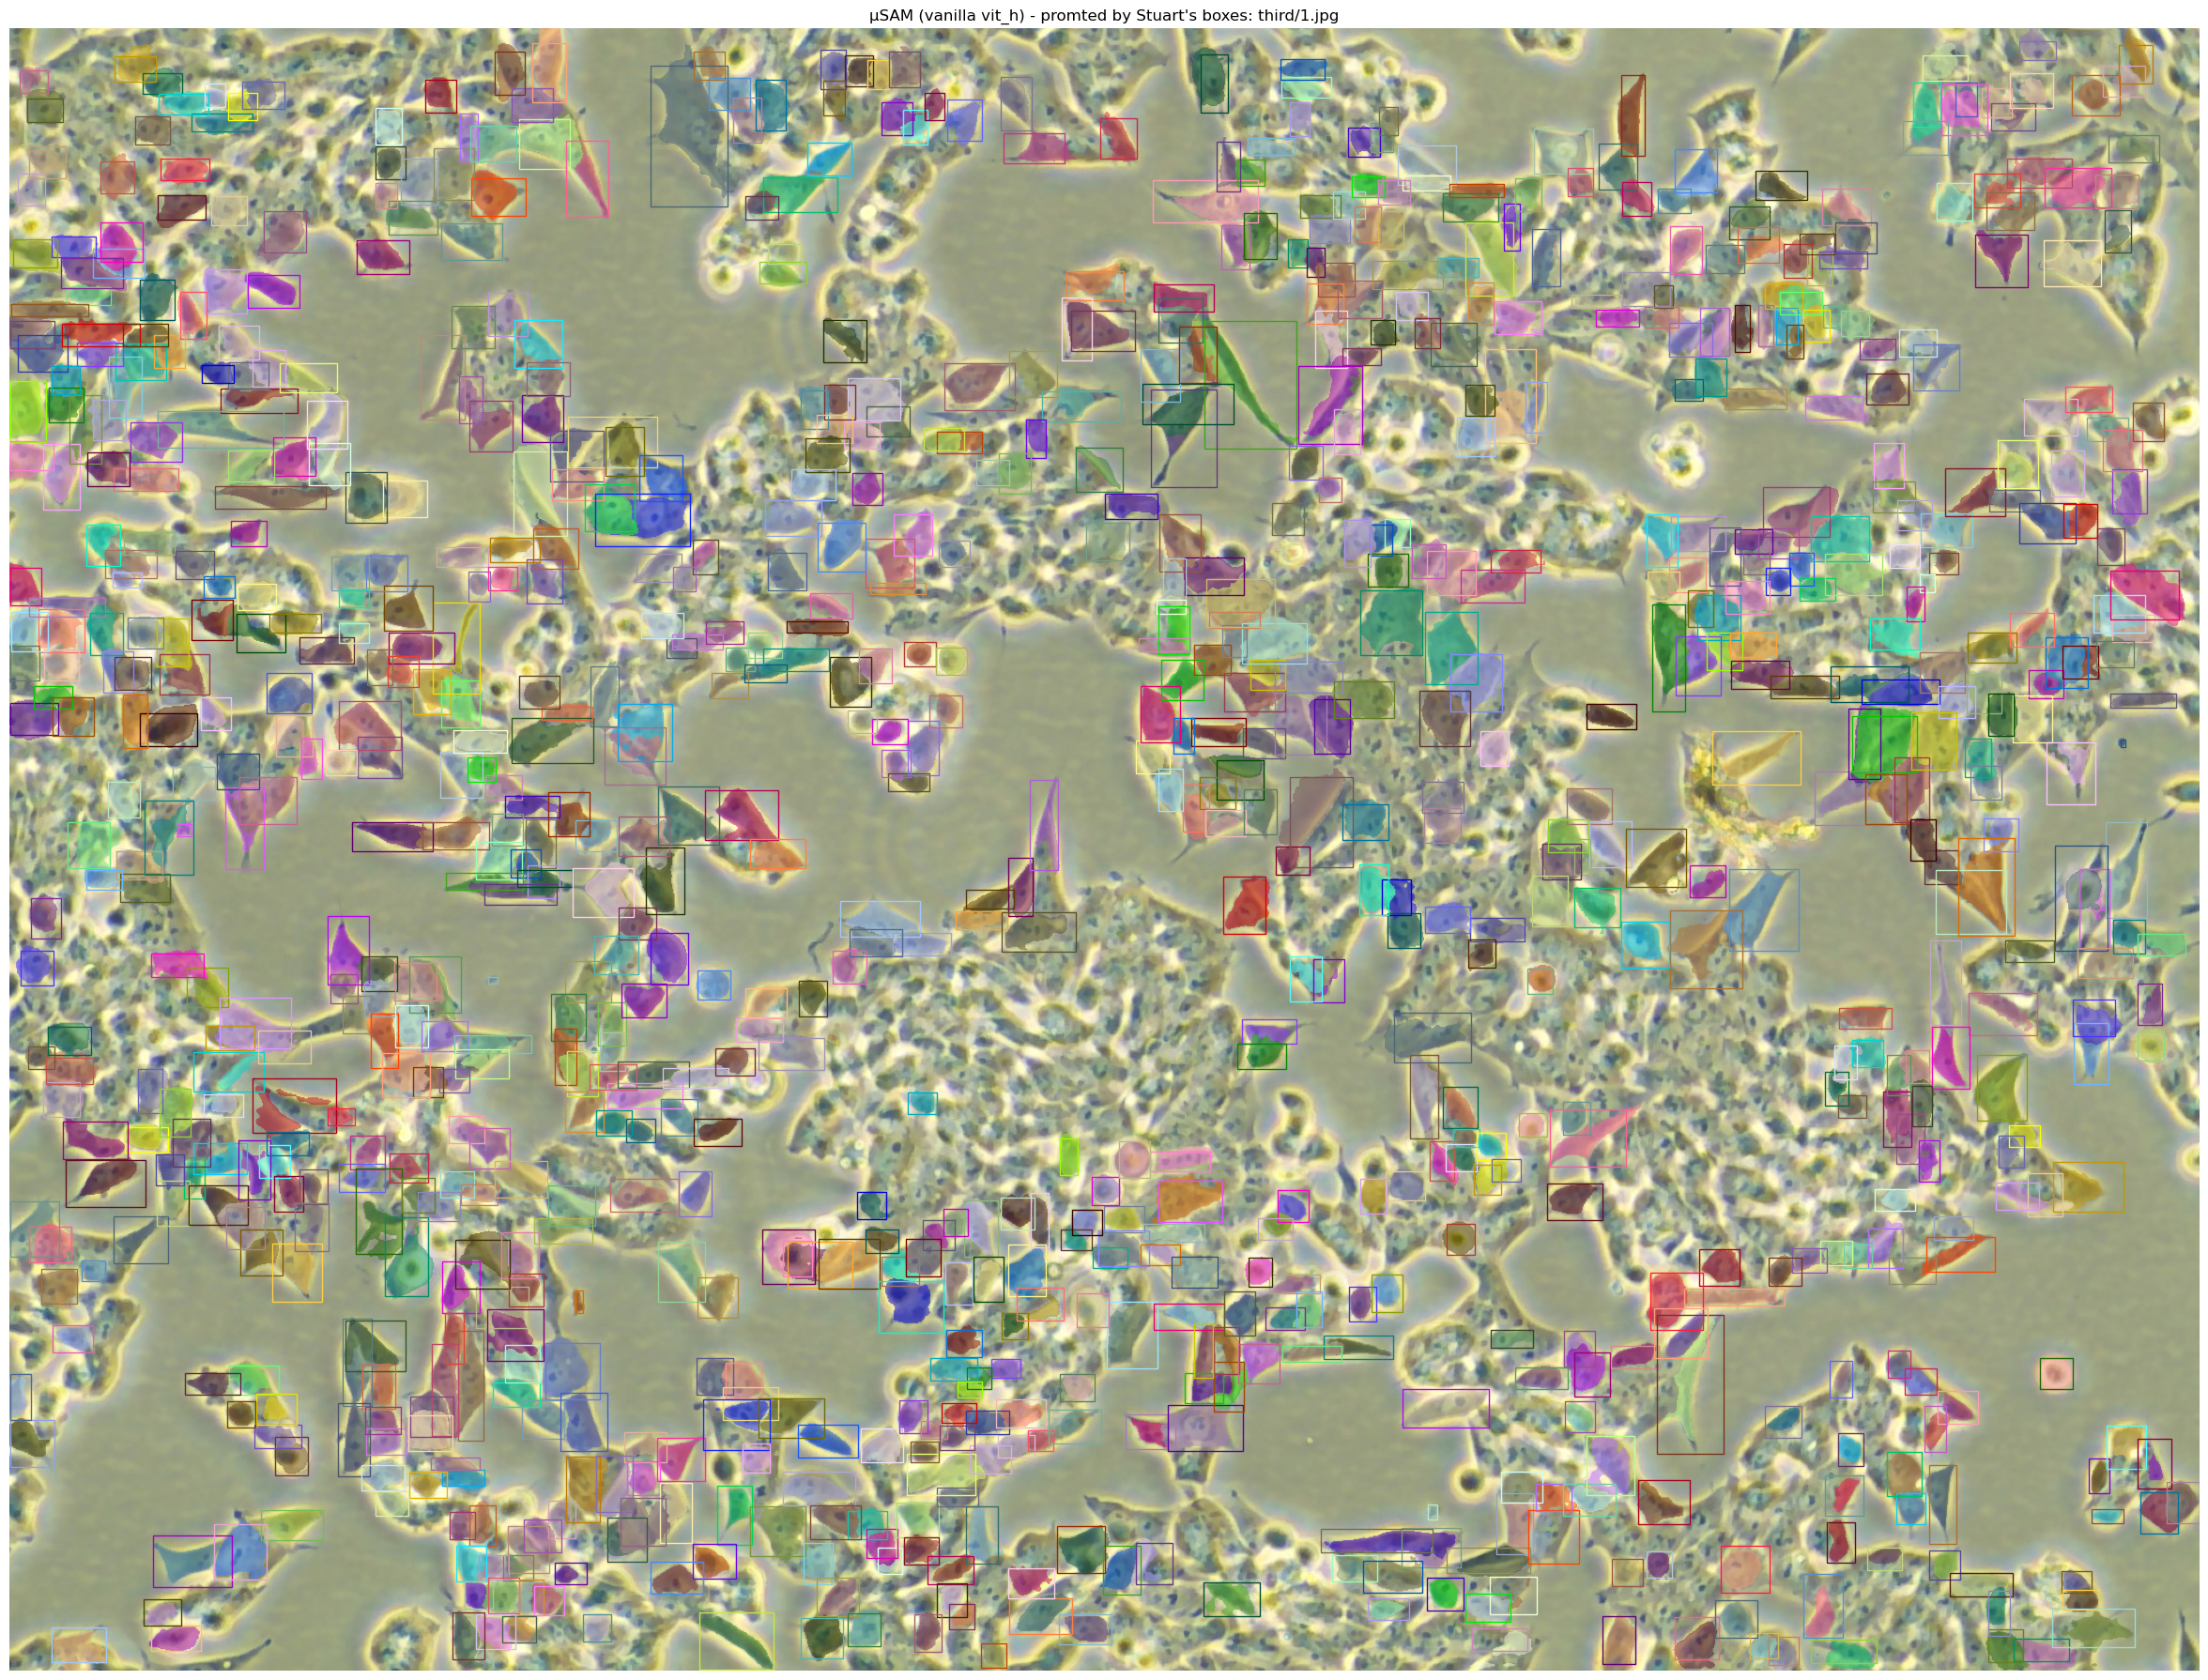

In [5]:

fig, ax = mk_fig(shape=image.shape)

out = skimage.color.label2rgb(
  masks, image, saturation=1, bg_color=None, alpha=0.5, colors=mk_colors(boxes))

plot_image(out, ax=ax, title=f"µSAM (vanilla {model_type}) - promted by Stuart\'s boxes: third/1.jpg")

plot_boxes(boxes, ax)